In [17]:
# Model Performance Testing in Google Colab with GPU

## 1. Install Required Dependencies

# Install required packages
!pip install opencv-python-headless tensorflow pillow

## 2. Upload Model Files
# Check if files exist, otherwise prompt for upload
import os
from google.colab import files

# Prepare for file uploads if needed
if not os.path.exists('/content/tf2_ssd_mobilenet_v2_coco17_ptq.tflite'):
    print("Please upload the TFLite model file (tf2_ssd_mobilenet_v2_coco17_ptq.tflite)")
    files.upload()  # This will prompt the user to upload the file

if not os.path.exists('/content/coco_labels.txt'):
    print("Please upload the COCO labels file (coco_labels.txt)")
    files.upload()  # This will prompt the user to upload the file

In [18]:
import logging
import numpy as np
import time
import cv2
import os
import io
import PIL.Image
from threading import Thread, Lock, Event
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from google.colab.output import eval_js
from IPython.display import display, Javascript
from base64 import b64decode

## 4. Check GPU Availability
print("TensorFlow version:", tf.__version__)
gpus = tf.config.list_physical_devices('GPU')
print("Available GPUs:", gpus)
if not gpus:
    sys.exit(1)

## 5. Camera Initialization Functions

# Function to initialize the camera
def init_camera():
    js = """
    // Global variables to ensure persistence
    var video = document.createElement('video');
    var canvasFrame = document.createElement('canvas');

    async function setupCamera() {
      if (!document.querySelector('#colab-camera-container')) {
        // Create container to hold the video element
        var container = document.createElement('div');
        container.id = 'colab-camera-container';
        container.style.display = 'block';
        container.style.width = '640px';
        container.style.height = '480px';
        container.style.overflow = 'hidden';
        document.body.appendChild(container);

        // Setup video element
        video.width = 640;
        video.height = 480;
        video.style.display = 'block';
        video.style.width = '100%';
        video.style.height = '100%';
        video.autoplay = true;
        container.appendChild(video);

        // Setup canvas
        canvasFrame.width = 640;
        canvasFrame.height = 480;
        canvasFrame.style.display = 'none';
        document.body.appendChild(canvasFrame);

        // Request camera access
        try {
          const stream = await navigator.mediaDevices.getUserMedia({
            'video': {
              width: { ideal: 640 },
              height: { ideal: 480 }
            }
          });

          video.srcObject = stream;

          // Wait for video to start playing
          return new Promise((resolve) => {
            video.onloadedmetadata = () => {
              video.play();
              resolve("Camera ready");
            };
          });
        } catch (error) {
          console.error('Error accessing camera', error);
          return "Camera error: " + error.message;
        }
      } else {
        return "Camera already initialized";
      }
    }

    setupCamera();
    """
    display(Javascript(js))
    # Give the browser a moment to set up the camera
    time.sleep(3)
    return True

# Function to capture a frame from the initialized webcam
def capture_frame():
    js = """
    function captureFrame() {
      var video = document.querySelector('video');
      var canvas = document.querySelector('canvas');

      if (!video || !canvas) {
        return null;
      }

      // Draw the current video frame to the canvas
      var ctx = canvas.getContext('2d');
      ctx.drawImage(video, 0, 0, canvas.width, canvas.height);

      // Get the image data as a JPEG
      return canvas.toDataURL('image/jpeg');
    }

    captureFrame();
    """

    # Get the image data
    data = eval_js(js)
    if data is None or data == 'null':
        return False, None

    # Convert the image data to OpenCV format
    binary = b64decode(data.split(',')[1])
    image = PIL.Image.open(io.BytesIO(binary))
    frame = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)

    return True, frame

## 6. LocalStreamGPU Implementation

class LocalStreamGPU:
    """
    Google Colab GPU stream implementation for performance testing.

    This class follows the same interface as AndonStream, LocalStreamCPU, and LocalStreamTPU
    to work with the existing performance testing framework.
    """
    def __init__(self, model_path=None, label_path=None):
        # Configure logging
        self.logger = logging.getLogger(self.__class__.__name__)
        logging.basicConfig(level=logging.INFO,
                         format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')
        self.logger.info("Initializing LocalStreamGPU in Google Colab")

        # Print TensorFlow version and GPU availability for debugging
        self.logger.info(f"TensorFlow version: {tf.__version__}")
        self.logger.info(f"GPU available: {tf.config.list_physical_devices('GPU')}")

        # Default paths for TFLite model (not EdgeTPU version)
        if model_path is None:
            model_path = '/content/tf2_ssd_mobilenet_v2_coco17_ptq.tflite'
        if label_path is None:
            label_path = '/content/coco_labels.txt'

        # Store configuration
        self.model_path = model_path
        self.label_path = label_path
        self.width = 640
        self.height = 480
        self.threshold = 0.6
        self.person_class_id = 0  # In COCO dataset, person class ID is 0

        # Performance metrics
        self.last_inference_time = 0
        self.last_capture_time = 0
        self.last_processing_time = 0

        # Detection results
        self.detected = False
        self.frame = None
        self.detections = []

        # Thread management
        self.running = Event()
        self.lock = Lock()
        self.thread = None

        # Initialize camera and model later in run()
        self.interpreter = None
        self.labels = None
        self.input_details = None
        self.output_details = None
        self.camera_initialized = False

    def run(self):
        """Start the streaming and detection process."""
        try:
            self.logger.info("Starting LocalStreamGPU on Colab")

            # Set GPU growth - prevents TensorFlow from allocating all GPU memory at once
            gpus = tf.config.experimental.list_physical_devices('GPU')
            if gpus:
                try:
                    for gpu in gpus:
                        tf.config.experimental.set_memory_growth(gpu, True)
                    self.logger.info(f"Set memory growth for {len(gpus)} GPUs")
                except RuntimeError as e:
                    self.logger.error(f"Error setting GPU memory growth: {e}")
            else:
                self.logger.warning("No GPU found. Will run on CPU instead.")

            # Initialize webcam for Colab
            self.logger.info("Setting up camera in Colab")
            self.camera_initialized = init_camera()
            if not self.camera_initialized:
                self.logger.error("Failed to initialize camera in Colab")
                return False

            # Test camera by capturing a single frame
            ret, test_frame = capture_frame()
            if not ret or test_frame is None:
                self.logger.error("Failed to capture test frame from camera")
                return False
            else:
                self.logger.info(f"Successfully captured test frame: {test_frame.shape}")

            # Check if model file exists
            if not os.path.exists(self.model_path):
                self.logger.error(f"Model file not found: {self.model_path}")
                return False

            # Load the TFLite model
            self.logger.info(f"Loading model: {self.model_path}")

            # Try GPU delegation first, fall back to CPU if needed
            try:
                # Try with GPU delegation
                self.interpreter = tf.lite.Interpreter(
                    model_path=self.model_path,
                    experimental_delegates=[
                        tf.lite.experimental.load_delegate('libdelegate.so')
                    ]
                )
                self.logger.info("Successfully loaded model with GPU delegation")
            except Exception as e:
                self.logger.warning(f"GPU delegation failed: {e}. Falling back to regular interpreter")
                # Fall back to regular interpreter
                self.interpreter = tf.lite.Interpreter(model_path=self.model_path)
                self.logger.info("Loaded model without GPU delegation")

            self.interpreter.allocate_tensors()

            # Get input and output tensors
            self.input_details = self.interpreter.get_input_details()
            self.output_details = self.interpreter.get_output_details()

            # Log tensor details for debugging
            self.logger.info(f"Input details: {self.input_details}")
            self.logger.info(f"Output details: {self.output_details}")

            # Load labels if available
            if os.path.exists(self.label_path):
                self.labels = self._load_labels(self.label_path)
                self.logger.info(f"Loaded {len(self.labels)} labels")
            else:
                self.logger.warning(f"Label file not found: {self.label_path}")
                self.labels = {0: 'person'}  # Fallback

            # Start processing thread
            self.running.set()
            self.thread = Thread(target=self._processing_thread)
            self.thread.daemon = True
            self.thread.start()

            self.logger.info("LocalStreamGPU started successfully")
            return True

        except Exception as e:
            self.logger.error(f"Failed to start LocalStreamGPU: {e}", exc_info=True)
            return False

    def _load_labels(self, path):
        """Load label file and return a dictionary mapping indices to labels."""
        with open(path, 'r') as f:
            lines = f.readlines()
        labels = {}
        for i, line in enumerate(lines):
            labels[i] = line.strip()
        return labels

    def _processing_thread(self):
        """Background thread for frame processing."""
        while self.running.is_set():
            try:
                # Measure frame capture time
                capture_start = time.time()

                # Capture frame from the webcam
                ret, frame = capture_frame()
                if not ret or frame is None:
                    self.logger.warning("Failed to capture frame from Colab camera")
                    time.sleep(0.5)  # Wait a bit longer when capture fails
                    continue

                # Calculate capture time in milliseconds
                capture_time = (time.time() - capture_start) * 1000

                # Process the frame
                process_start = time.time()
                detections, inference_time = self._process_frame(frame)
                process_time = (time.time() - process_start) * 1000

                # Log detections for debugging
                if detections:
                    detection_info = []
                    for d in detections:
                        class_id, score = d[1], d[2]
                        class_name = self.labels.get(class_id, f"Unknown({class_id})")
                        detection_info.append(f"{class_name}: {score:.2f}")
                    self.logger.debug(f"Detections: {detection_info}")

                # Check for person detections
                detected = False
                for detection in detections:
                    class_id = int(detection[1])
                    confidence = detection[2]
                    if class_id == self.person_class_id and confidence > self.threshold:
                        detected = True
                        self.logger.debug(f"Person detected with confidence: {confidence:.2f}")
                        break

                # Update state with thread safety
                with self.lock:
                    self.frame = frame
                    self.detections = detections
                    self.detected = detected
                    self.last_inference_time = inference_time
                    self.last_capture_time = capture_time
                    self.last_processing_time = process_time

                # Short delay to reduce CPU usage
                time.sleep(0.1)

            except Exception as e:
                self.logger.error(f"Error in processing thread: {e}", exc_info=True)
                time.sleep(0.5)

    def _process_frame(self, frame):
        """
        Process a frame using TFLite model on GPU.

        Args:
            frame: The image frame to process

        Returns:
            (detections, inference_time): List of detections and inference time in ms
        """
        try:
            # Get input size from model
            input_shape = self.input_details[0]['shape']
            input_height, input_width = input_shape[1], input_shape[2]

            # Prepare the frame for the model
            input_frame = cv2.resize(frame, (input_width, input_height))
            # Convert to RGB as models are typically trained on RGB
            input_frame = cv2.cvtColor(input_frame, cv2.COLOR_BGR2RGB)

            # Use UINT8 as required by the model
            input_frame = input_frame.astype(np.uint8)

            # Add batch dimension
            input_frame = np.expand_dims(input_frame, axis=0)

            # Set the input tensor
            self.interpreter.set_tensor(self.input_details[0]['index'], input_frame)

            # Measure inference time
            start_time = time.time()
            self.interpreter.invoke()
            inference_time = (time.time() - start_time) * 1000

            # Get output tensors
            # Extract the outputs based on their indices
            detection_boxes = self.interpreter.get_tensor(self.output_details[0]['index'])
            detection_classes = self.interpreter.get_tensor(self.output_details[1]['index'])
            detection_scores = self.interpreter.get_tensor(self.output_details[2]['index'])

            # Log shapes for debugging
            self.logger.debug(f"detection_boxes shape: {detection_boxes.shape}")
            self.logger.debug(f"detection_classes shape: {detection_classes.shape}")
            self.logger.debug(f"detection_scores shape: {detection_scores.shape}")

            # Process results
            detections = []

            # Check if the overall detection score passes our threshold
            if detection_scores.shape == (1,) and detection_scores[0] > self.threshold:
                overall_score = float(detection_scores[0])
                self.logger.debug(f"Overall detection score: {overall_score}")

                # Look through the class probabilities for person detections
                if len(detection_classes.shape) == 3 and detection_classes.shape[2] >= 1:
                    num_detections = detection_classes.shape[1]

                    for i in range(num_detections):
                        # Get the probability for person class (index 0)
                        # Access with safety checks
                        if detection_classes.shape[2] > self.person_class_id:
                            person_prob = float(detection_classes[0, i, self.person_class_id])

                            # If person probability is high enough
                            if person_prob > self.threshold:
                                self.logger.debug(f"Detected person with probability: {person_prob:.4f}")

                                # Calculate a reasonable bounding box (centered, 80% of frame)
                                width = frame.shape[1]
                                height = frame.shape[0]
                                box_width = int(width * 0.8)
                                box_height = int(height * 0.8)
                                xmin = int((width - box_width) / 2)
                                ymin = int((height - box_height) / 2)
                                xmax = xmin + box_width
                                ymax = ymin + box_height

                                # Add detection
                                detections.append((
                                    i,                     # detection ID
                                    self.person_class_id,  # class ID (person)
                                    person_prob,           # confidence score
                                    (xmin, ymin, xmax, ymax)  # estimated bounding box
                                ))

            return detections, inference_time

        except Exception as e:
            self.logger.error(f"Error processing frame: {e}", exc_info=True)
            import traceback
            self.logger.error(traceback.format_exc())
            return [], 0

    def get_latest_inference_time(self):
        """
        Get the latest inference time (time taken for model to process image).

        Returns:
            float: Inference time in milliseconds or None if not available
        """
        with self.lock:
            return self.last_inference_time if self.last_inference_time > 0 else None

    def get_latest_end_to_end_time(self):
        """
        Get the end-to-end latency including capture and processing.

        Returns:
            float: End-to-end latency in milliseconds or None if not available
        """
        with self.lock:
            if self.last_inference_time <= 0:
                return None

            # Calculate total latency (capture + processing)
            total_time = self.last_capture_time + self.last_processing_time
            return total_time

    def get_latest_detection_status(self):
        """
        Get the latest detection status.

        Returns:
            bool: True if person detected, False otherwise
        """
        with self.lock:
            return self.detected

    def stop(self):
        """Stop streaming and release resources."""
        self.logger.info("Stopping LocalStreamGPU")
        self.running.clear()

        if self.thread and self.thread.is_alive():
            self.thread.join(timeout=2.0)

        # Clean up camera resources with JavaScript
        js = """
        var video = document.querySelector('video');
        var container = document.querySelector('#colab-camera-container');

        if (video && video.srcObject) {
          video.srcObject.getTracks().forEach(track => track.stop());
        }

        if (container) {
          container.remove();
        }
        """
        try:
            display(Javascript(js))
        except:
            pass

        self.logger.info("LocalStreamGPU stopped")






TensorFlow version: 2.18.0
Available GPUs: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [25]:
"""
Logging code for streaming scripts. Logs key times from different model deployments.
"""


import argparse
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import os
import sys



# Cloud is implemented using google collab notebook, where the class is defined in the same notebook

class DataSampler:
    """Samples data from a detection stream at regular intervals."""
    def __init__(self, stream, sample_interval=0.1):
        self.stream = stream
        self.sample_interval = sample_interval
        self.samples = []

    def sample(self, num_samples=100, require_detection=True):
        """
        Collect specified number of samples from the stream.

        Args:
            num_samples: Number of valid samples to collect
            require_detection: If True, only collect samples with successful detections

        Returns:
            list: Collected samples with performance metrics
        """
        print(f"Starting sampling process for {num_samples} samples...")
        collected = 0

        while collected < num_samples:

            detected = self.stream.get_latest_detection_status()


            if detected is False:
                time.sleep(self.sample_interval)
                continue

            # Get latest inference time
            inference_time = self.stream.get_latest_inference_time()

            # Get latest end-to-end time
            end_to_end_time = self.stream.get_latest_end_to_end_time()


            # Skip if no valid data
            if inference_time is None or end_to_end_time is None:
                time.sleep(self.sample_interval)
                continue

            # Create sample record
            sample = {
                'timestamp': datetime.now().isoformat(),
                'inference_time': inference_time,
                'end_to_end_time': end_to_end_time
            }

            self.samples.append(sample)
            collected += 1

            if collected % 10 == 0:
                print(f"Collected {collected}/{num_samples} samples")

            time.sleep(self.sample_interval)

        print(f"Sampling complete. Collected {len(self.samples)} samples.")
        return self.samples

class DataAnalyzer:
    """
    Analyzes performance data from detection samples and
    generates visualizations and reports.
    """
    def __init__(self, samples, deployment_type="andon"):
        self.samples = samples
        self.deployment_type = deployment_type
        self.df = pd.DataFrame(samples)
        self.results = self._analyze()

    def _analyze(self):
        """Analyze the collected samples and compute statistics."""
        if len(self.df) == 0:
            return None

        # Calculate basic statistics for inference time
        inference_stats = {
            'mean': self.df['inference_time'].mean(),
            'median': self.df['inference_time'].median(),
            'std': self.df['inference_time'].std(),
            'min': self.df['inference_time'].min(),
            'max': self.df['inference_time'].max(),
            'percentile_95': np.percentile(self.df['inference_time'], 95)
        }

        # Calculate basic statistics for end-to-end time
        end_to_end_stats = {
            'mean': self.df['end_to_end_time'].mean(),
            'median': self.df['end_to_end_time'].median(),
            'std': self.df['end_to_end_time'].std(),
            'min': self.df['end_to_end_time'].min(),
            'max': self.df['end_to_end_time'].max(),
            'percentile_95': np.percentile(self.df['end_to_end_time'], 95)
        }

        return {
            'deployment_type': self.deployment_type,
            'sample_count': len(self.df),
            'inference_stats': inference_stats,
            'end_to_end_stats': end_to_end_stats
        }

    def output_figures(self, output_dir="./results"):
        """Generate visualization figures for the data."""
        import os
        os.makedirs(output_dir, exist_ok=True)

        # Create timestamp for unique filenames
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Plot inference time distribution
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['inference_time'], bins=20, alpha=0.7, color='blue')
        plt.title(f'Inference Time Distribution - {self.deployment_type}')
        plt.xlabel('Inference Time (ms)')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(f"{output_dir}/{self.deployment_type}_inference_time_{timestamp}.png")

        # Plot end-to-end time distribution
        plt.figure(figsize=(10, 6))
        plt.hist(self.df['end_to_end_time'], bins=20, alpha=0.7, color='green')
        plt.title(f'End-to-End Latency Distribution - {self.deployment_type}')
        plt.xlabel('End-to-End Time (ms)')
        plt.ylabel('Frequency')
        plt.grid(True, linestyle='--', alpha=0.7)
        plt.savefig(f"{output_dir}/{self.deployment_type}_end_to_end_time_{timestamp}.png")

        # Print summary to console
        self._print_summary()

    def output_csv(self, output_dir="./results"):
        """Save the raw data and analysis results to CSV files."""
        import os
        os.makedirs(output_dir, exist_ok=True)

        # Create timestamp for unique filenames
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

        # Save raw data
        self.df.to_csv(f"{output_dir}/{self.deployment_type}_raw_data_{timestamp}.csv", index=False)

        # Save analysis results
        results_df = pd.DataFrame({
            'metric': [
                'sample_count',
                'inference_mean', 'inference_median', 'inference_std', 'inference_min', 'inference_max', 'inference_95p',
                'e2e_mean', 'e2e_median', 'e2e_std', 'e2e_min', 'e2e_max', 'e2e_95p'
            ],
            'value': [
                self.results['sample_count'],
                self.results['inference_stats']['mean'],
                self.results['inference_stats']['median'],
                self.results['inference_stats']['std'],
                self.results['inference_stats']['min'],
                self.results['inference_stats']['max'],
                self.results['inference_stats']['percentile_95'],
                self.results['end_to_end_stats']['mean'],
                self.results['end_to_end_stats']['median'],
                self.results['end_to_end_stats']['std'],
                self.results['end_to_end_stats']['min'],
                self.results['end_to_end_stats']['max'],
                self.results['end_to_end_stats']['percentile_95']
            ]
        })

        results_df.to_csv(f"{output_dir}/{self.deployment_type}_analysis_{timestamp}.csv", index=False)
        print(f"Results saved to {output_dir}")

    def _print_summary(self):
        """Print a summary of the analysis results to the console."""
        print("\n" + "="*50)
        print(f"PERFORMANCE SUMMARY - {self.deployment_type.upper()}")
        print("="*50)
        print(f"Samples collected: {self.results['sample_count']}")

        print("\nINFERENCE TIME STATISTICS (ms):")
        print(f"  Mean:      {self.results['inference_stats']['mean']:.2f}")
        print(f"  Median:    {self.results['inference_stats']['median']:.2f}")
        print(f"  Std Dev:   {self.results['inference_stats']['std']:.2f}")
        print(f"  Min:       {self.results['inference_stats']['min']:.2f}")
        print(f"  Max:       {self.results['inference_stats']['max']:.2f}")
        print(f"  95th Perc: {self.results['inference_stats']['percentile_95']:.2f}")

        print("\nEND-TO-END LATENCY STATISTICS (ms):")
        print(f"  Mean:      {self.results['end_to_end_stats']['mean']:.2f}")
        print(f"  Median:    {self.results['end_to_end_stats']['median']:.2f}")
        print(f"  Std Dev:   {self.results['end_to_end_stats']['std']:.2f}")
        print(f"  Min:       {self.results['end_to_end_stats']['min']:.2f}")
        print(f"  Max:       {self.results['end_to_end_stats']['max']:.2f}")
        print(f"  95th Perc: {self.results['end_to_end_stats']['percentile_95']:.2f}")
        print("="*50)


<IPython.core.display.Javascript object>

Exception ignored in: <function Delegate.__del__ at 0x791f053f2480>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/interpreter.py", line 109, in __del__
    if self._library is not None:
       ^^^^^^^^^^^^^
AttributeError: 'Delegate' object has no attribute '_library'


Starting sampling process for 100 samples...
Collected 10/100 samples
Collected 20/100 samples
Collected 30/100 samples
Collected 40/100 samples
Collected 50/100 samples
Collected 60/100 samples
Collected 70/100 samples
Collected 80/100 samples
Collected 90/100 samples
Collected 100/100 samples
Sampling complete. Collected 100 samples.

PERFORMANCE SUMMARY - CLOUD_GPU
Samples collected: 100

INFERENCE TIME STATISTICS (ms):
  Mean:      29.33
  Median:    28.18
  Std Dev:   3.46
  Min:       26.67
  Max:       40.25
  95th Perc: 38.41

END-TO-END LATENCY STATISTICS (ms):
  Mean:      177.66
  Median:    183.64
  Std Dev:   34.38
  Min:       106.85
  Max:       242.49
  95th Perc: 210.95
Results saved to /content/results
Stopping stream...


<IPython.core.display.Javascript object>

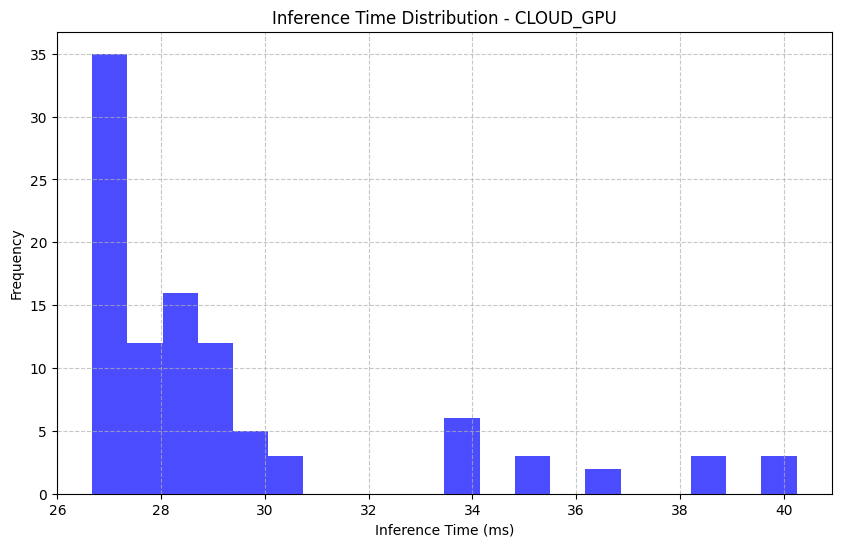

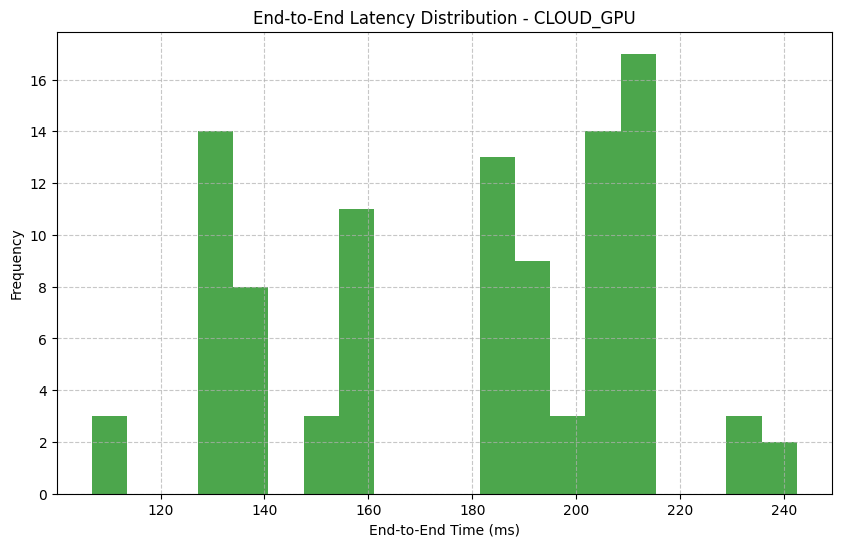

In [33]:

def test_gpu_stream(duration=10):
    """Quick test for the GPU stream to validate it's working."""
    print("Testing LocalStreamGPU in Google Colab...")
    stream = LocalStreamGPU()
    if stream.run():
        print("Stream started successfully")

        try:
            # Display basic stats for specified duration
            start_time = time.time()
            while time.time() - start_time < duration:
                time.sleep(1)
                detected = stream.get_latest_detection_status()
                inference_time = stream.get_latest_inference_time()
                end_to_end_time = stream.get_latest_end_to_end_time()

                print(f"Detection: {detected}")
                print(f"Inference time: {inference_time} ms")
                print(f"End-to-end time: {end_to_end_time} ms")
                print("-" * 30)

        finally:
            stream.stop()
    else:
        print("Failed to start stream")

def stream_log():
    try:
      output_dir = "/content/results"
      deployment_type = "CLOUD_GPU"
      samples=100
      interval=0.1
      os.makedirs(output_dir, exist_ok=True)

      stream=LocalStreamGPU()
      stream.run()

    except Exception as e:
        print(f"Error: {e}")
        sys.exit(1)

    try:
        data_sampler = DataSampler(stream, sample_interval=interval)
        data = data_sampler.sample(num_samples=samples)

        analyzer = DataAnalyzer(data, deployment_type=deployment_type)
        analyzer.output_figures(output_dir=output_dir)
        analyzer.output_csv(output_dir=output_dir)

    finally:
        # Clean up
        if stream:
            print("Stopping stream...")
            stream.stop()


stream_log()
#test_gpu_stream()
